In [2]:
import numpy as np
import pandas as pd

# from data import gen_adult_probs_old
from fair_baselines.feldman import RandomForestClassifier, get_eval_single
from fairlearn.metrics import selection_rate, true_positive_rate, false_positive_rate

from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.datasets.adult_dataset import AdultDataset


In [35]:
ad = AdultDataset(protected_attribute_names=['sex'],
    privileged_classes=[['Male']], categorical_features=[],
    features_to_keep=['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']) #, 'workclass'])

In [36]:
test, train = ad.split([16281])

In [37]:
len(train.convert_to_dataframe()[0])

32561

In [38]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(copy=False)

train.features = scaler.fit_transform(train.features)
test.features = scaler.fit_transform(test.features)

index = train.feature_names.index('sex')

In [39]:
train.features[:,2]

array([1., 1., 1., ..., 0., 1., 0.])

In [47]:
train.feature_names

['age',
 'education-num',
 'sex',
 'capital-gain',
 'capital-loss',
 'hours-per-week']

In [91]:
def gen_feldman_probs(seed=0, repairlevels=np.linspace(0.1,1,10), verbose=False):
    X, labels, sens = gen_adult_probs_old(seed, interv='pre/in')

    # first try all repair levels for PR, TPR, and EO (using half the data)
    # split_ind = int(len(X)/2)

    # Xcombined = np.concatenate([sens.reshape(-1,1),X], axis=1) # combine for the feldman repairer
    # trainx, testx = Xcombined[:split_ind], Xcombined[split_ind:] 
    # trainL, testL = labels[:split_ind], labels[split_ind:]
    
    all_repairlevels = pd.DataFrame(columns=['repairlevel', 'avg_prd', 'avg_tprd', 'avg_eod', 'avg_acc'])
    
    # print(type(trainx))

    if verbose:
        print("Checking all repair levels")

    for repairlevel in repairlevels:

        if verbose:
            print("Checking repair level", repairlevel)
            # print("trainx shape", trainx.shape)

        # repairer = Repairer(trainx, 0, repairlevel, False)
        di = DisparateImpactRemover(repair_level=repairlevel)
        
        train_repd = di.fit_transform(train)
        test_repd = di.fit_transform(test)
        # train_repd = np.array(repairer.repair(trainx))

        X_tr = np.delete(train_repd.features, index, axis=1)
        X_te = np.delete(test_repd.features, index, axis=1)
        y_tr = train_repd.labels.ravel()
        y_te = test_repd.labels.ravel()
        classifier = RandomForestClassifier(random_state=seed).fit(X_tr,y_tr)
        probs = classifier.predict_proba(X_te)[:,1]

        # tmpsplit = int(len(train_repd)/2) # this split - first half to train the RF, second half as "val"
        # classifier = RandomForestClassifier(random_state=seed).fit(train_repd[:tmpsplit, 1:], trainL[:tmpsplit])
        # probs = classifier.predict_proba(train_repd[tmpsplit:, 1:])[:,1]

        # get the average PR, TPR, and FPR for each group at each threshold
        grp = test.features[:,index]
        results = get_eval_single(y_te,probs,grp)
        # grp = trainx[tmpsplit:,0]
        # results = get_eval_single(trainL[tmpsplit:], probs, grp)

        # get results for threshold = 0.5
        ind05 = results.loc[results ['thresholds'] == 0.5] 
        prd05 = ind05['positivity_rate_differences']
        acc05 = ind05['acc_overall']
        tprd05 = ind05['tpr_differences']
        fprd05 = ind05['fpr_differences']
        # preds05 = probs > 0.5
        # prd05 = np.abs(np.mean(preds05[grp == 0]) - np.mean(preds05[grp == 1]))
        # acc05 = np.mean(preds05 == y_te)
        # tprd05 = np.abs(true_positive_rate(y_te[grp==0],preds05[grp==0]) - true_positive_rate(y_te[grp==1],preds05[grp==1]))
        # fprd05 = np.abs(false_positive_rate(y_te[grp==0],preds05[grp==0]) - false_positive_rate(y_te[grp==1],preds05[grp==1]))

        all_repairlevels = all_repairlevels.append({
            'repairlevel': repairlevel,
            'avg_prd': np.mean(np.abs(results['positivity_rate_differences'])),
            'avg_tprd': np.mean(np.abs(results['tpr_differences'])),
            'avg_eod': np.mean(results['eqodds_differences']),
            'avg_acc': np.mean(results['acc_overall']), 
            '05_prd': prd05.values[0],
            '05_tprd': tprd05.values[0],
            '05_eod': (np.abs(tprd05) + np.abs(fprd05)).values[0],
            '05_acc': acc05.values[0]
        }, ignore_index=True)

    if verbose:
        print("Checked all repair levels, saving best results")

    # return all_repairlevels # for debugging only
    # then find the best repair level for each and return the probabilities (using other half of data)
    best_repairlevels = {}
    metr_probs = {}
    for metr in ['pr', 'tpr', 'eo', 'acc']:
        if metr == 'acc':
            best_repairlevels[metr] = all_repairlevels['repairlevel'][all_repairlevels['avg_' + metr].argmin()]

        else:
            best_repairlevels[metr] = all_repairlevels['repairlevel'][all_repairlevels['avg_' + metr +'d'].argmin()]

        # recover the right classifier
        repairer = DisparateImpactRemover(repair_level=best_repairlevels[metr])
        train_repd = repairer.fit_transform(train)
        test_repd = repairer.fit_transform(test)

        X_tr = np.delete(train_repd.features, index, axis=1)
        X_te = np.delete(test_repd.features, index, axis=1)
        y_tr = train_repd.labels.ravel()
        y_te = test_repd.labels.ravel()
        classifier = RandomForestClassifier(random_state=seed).fit(X_tr,y_tr)
        probs = classifier.predict_proba(X_te)[:,1]
        metr_probs[metr] = probs
        
    repaired_scores = pd.DataFrame({
        'scores_pr': metr_probs['pr'], 
        'scores_tpr': metr_probs['tpr'], 
        'scores_eo': metr_probs['eo'], 
        'scores_acc': metr_probs['acc'], 
        'labels': y_te, 
        'groups': test_repd.protected_attributes.reshape(-1)
    })

    return repaired_scores, best_repairlevels, all_repairlevels

In [94]:
np.linspace(0,1,21)

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [70]:
metr_probs, y_te, y_prot = tmp[0], tmp[1], tmp[2]

repaired_scores = pd.DataFrame({
    'scores_pr': metr_probs['pr'], 
    'scores_tpr': metr_probs['tpr'], 
    'scores_eo': metr_probs['eo'], 
    'scores_acc': metr_probs['acc'], 
    'labels': y_te, 
    'groups': y_prot.reshape(-1)
})

In [72]:
repaired_scores

,scores_pr,scores_tpr,scores_eo,scores_acc,labels,groups
0,0.000000,0.000000,0.000000,0.000000,0.0,1.0
1,0.337473,0.337473,0.337473,0.323089,0.0,1.0
2,0.006176,0.006176,0.006176,0.204335,1.0,1.0
3,0.830000,0.830000,0.830000,1.000000,1.0,1.0
4,0.000000,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...
16276,0.463757,0.463757,0.463757,0.463757,0.0,0.0
16277,0.341167,0.341167,0.341167,0.217317,0.0,1.0
16278,0.763251,0.763251,0.763251,0.716161,0.0,1.0
16279,0.853214,0.853214,0.853214,0.930000,0.0,1.0


In [92]:
tmp = gen_feldman_probs(repairlevels=[1], verbose=True)

Checking all repair levels
Checking repair level 1
Checked all repair levels, saving best results


In [93]:
tmp[2]

,repairlevel,avg_prd,avg_tprd,avg_eod,avg_acc,05_acc,05_eod,05_prd,05_tprd
0,1.0,0.100973,0.057387,0.095091,0.770907,0.805295,0.121917,0.111181,0.081858


In [77]:
tmp[0]

,scores_pr,scores_tpr,scores_eo,scores_acc,labels,groups
0,0.000000,0.000000,0.000000,0.000000,0.0,1.0
1,0.337473,0.337473,0.337473,0.323089,0.0,1.0
2,0.006176,0.006176,0.006176,0.204335,1.0,1.0
3,0.830000,0.830000,0.830000,1.000000,1.0,1.0
4,0.000000,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...
16276,0.463757,0.463757,0.463757,0.463757,0.0,0.0
16277,0.341167,0.341167,0.341167,0.217317,0.0,1.0
16278,0.763251,0.763251,0.763251,0.716161,0.0,1.0
16279,0.853214,0.853214,0.853214,0.930000,0.0,1.0


In [78]:
tmp[1]

{'pr': 0.7000000000000001,
 'tpr': 0.7000000000000001,
 'eo': 0.7000000000000001,
 'acc': 0.6}

In [111]:
ad.feature_names

['age',
 'education-num',
 'sex',
 'capital-gain',
 'capital-loss',
 'hours-per-week']

In [79]:
tmp[2]

,repairlevel,avg_prd,avg_tprd,avg_eod,avg_acc,05_acc,05_eod,05_prd,05_tprd
0,0.1,0.161175,0.114740,0.209825,0.767042,0.811559,0.190679,0.142690,0.127324
1,0.2,0.158192,0.101953,0.195215,0.767248,0.812788,0.169558,0.143237,0.103572
2,0.3,0.150438,0.095294,0.182078,0.764492,0.810945,0.156852,0.133474,0.099307
3,0.4,0.116329,0.063158,0.116332,0.773372,0.808734,0.116281,0.115242,0.070460
4,0.5,0.104256,0.052607,0.095199,0.773359,0.807997,0.108768,0.114599,0.061235
5,0.6,0.125418,0.062554,0.128247,0.763543,0.810761,0.077971,0.099575,0.048130
6,0.7,0.080305,0.028059,0.056399,0.770871,0.808427,0.079020,0.103540,0.041226
7,0.8,0.124760,0.086813,0.145601,0.769558,0.807383,0.170824,0.130893,0.116893
8,0.9,0.115658,0.076086,0.126508,0.770356,0.806891,0.146817,0.122237,0.098147
9,1.0,0.100973,0.057387,0.095091,0.770907,0.805295,0.121917,0.111181,0.081858


In [118]:
feldscores = pd.read_csv('fair_baselines/fb_results/feldman__scores.csv')
feldscores.loc[feldscores.trial == 9]

,trial,scores_pr,scores_tpr,scores_eo,scores_acc,labels,groups
146520,9,0.322500,0.300000,0.300000,0.220000,0.0,1.0
146521,9,0.920000,1.000000,1.000000,1.000000,1.0,1.0
146522,9,0.069952,0.057690,0.057690,0.036690,0.0,1.0
146523,9,0.013140,0.074186,0.074186,0.301388,0.0,1.0
146524,9,0.319639,0.294806,0.294806,0.070028,0.0,0.0
...,...,...,...,...,...,...,...
162795,9,0.000000,0.021727,0.021727,0.048130,0.0,1.0
162796,9,0.035000,0.036429,0.036429,0.084446,0.0,1.0
162797,9,0.960000,0.980000,0.980000,0.931667,1.0,1.0
162798,9,0.190000,0.160000,0.160000,0.320000,0.0,1.0


In [19]:
feldbestlevels = pd.read_csv('fair_baselines/adult_new_results/feldman__bestlevels.csv')
feldbestlevels#.head()

,trial,pr,tpr,eo,acc
0,0.0,0.95,0.95,0.95,1.00
1,1.0,0.15,0.50,0.15,0.65
2,2.0,0.30,0.95,0.30,0.80
3,3.0,0.95,0.95,0.95,0.45
4,4.0,0.45,0.40,0.45,0.90
5,5.0,0.60,0.20,0.20,0.90
6,6.0,1.00,0.85,0.85,0.25
7,7.0,1.00,0.95,0.95,0.95
8,8.0,0.65,0.80,0.80,0.45
9,9.0,0.95,0.95,0.95,0.45


<AxesSubplot:>

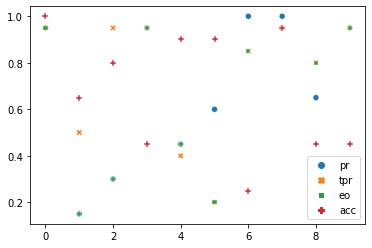

In [25]:
sns.scatterplot(data=feldbestlevels.drop(columns=['trial']))

In [8]:
import seaborn as sns

<AxesSubplot:xlabel='repairlevel', ylabel='avg_tprd'>

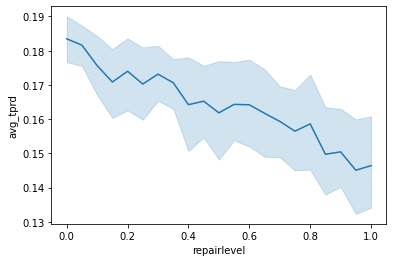

In [17]:
sns.lineplot(data=feldoverlevels, x='repairlevel', y='avg_tprd')

In [ ]:
feldoverlevels = pd.read_csv('fair_baselines/adult_new_results/feldman__overlevels.csv')
feldoverlevels.head(21)

,trial,repairlevel,avg_prd,avg_tprd,avg_eod,avg_acc,05_acc,05_eod,05_prd,05_tprd
0,0,0.00,0.195653,0.178853,0.291811,0.777280,0.822063,0.262620,0.173463,0.187762
1,0,0.05,0.194781,0.177751,0.289938,0.777410,0.822800,0.260591,0.172173,0.187462
2,0,0.10,0.180353,0.156832,0.259105,0.776144,0.816289,0.293129,0.186455,0.203704
3,0,0.15,0.193005,0.166017,0.282180,0.771949,0.815859,0.252071,0.171989,0.171762
4,0,0.20,0.188673,0.157604,0.270992,0.771674,0.814876,0.241502,0.166459,0.164576
5,0,0.25,0.177085,0.150995,0.251190,0.775869,0.815675,0.282519,0.182032,0.195901
6,0,0.30,0.188820,0.161079,0.274041,0.771835,0.815552,0.248606,0.167013,0.173392
7,0,0.35,0.188941,0.161411,0.274378,0.771910,0.817087,0.244127,0.164432,0.171797
8,0,0.40,0.176660,0.143029,0.246246,0.772840,0.812911,0.271865,0.179545,0.183990
9,0,0.45,0.168964,0.135760,0.231156,0.774855,0.813832,0.253939,0.171251,0.173186
